(128, 128)


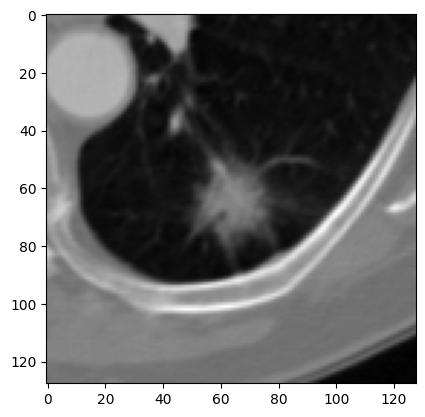

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
slice=1
img_name='/kaggle/input/lidcidri/LIDC-IDRI-slices/LIDC-IDRI-0001/nodule-0/images/slice-'+str(slice)+'.png'
image = Image.open(img_name).convert("L")
arr = np.asarray(image)
print(arr.shape)
plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.show()

(128, 128)


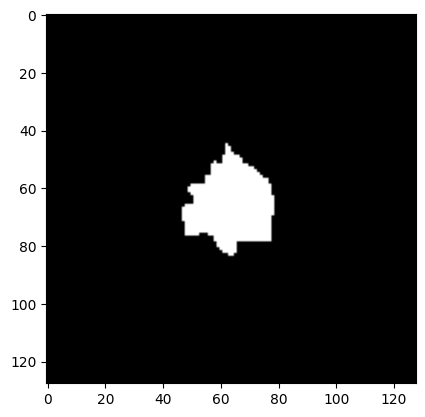

(128, 128)


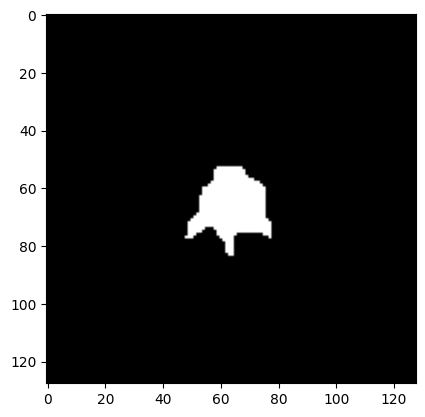

(128, 128)


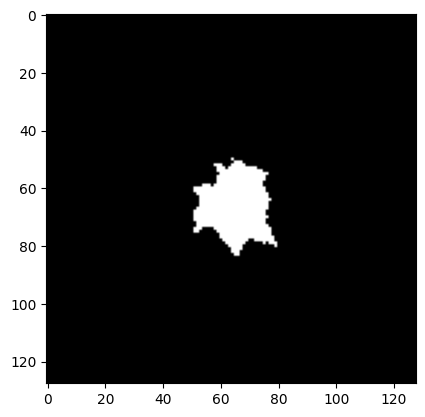

(128, 128)


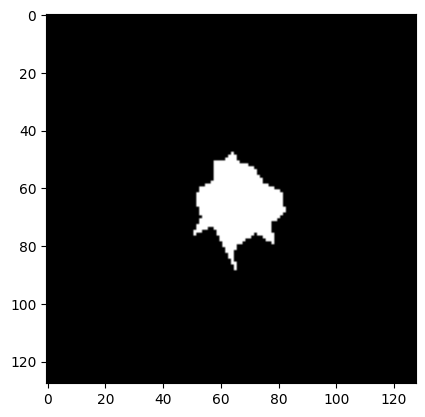

In [2]:
masks=[0, 1, 2, 3]
slice=1
ans=[]
for mask in masks :
    img_name='/kaggle/input/lidcidri/LIDC-IDRI-slices/LIDC-IDRI-0001/nodule-0/mask-'+str(mask)+'/slice-'+str(slice)+'.png'
    image = Image.open(img_name).convert("L")
    arr = np.asarray(image)
    ans.append(arr)
    print(arr.shape)
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
    plt.show()

(4, 128, 128)


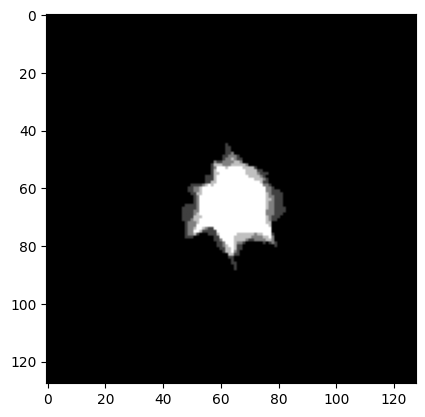

In [3]:
ans=np.array(ans)
print(ans.shape)
intersection_mask = np.mean(ans, axis=0)
intersection_mask.shape
plt.imshow(intersection_mask, cmap='gray', vmin=0, vmax=255)
plt.show()

In [4]:
import pickle
with open('/kaggle/input/images-split/data_split.pkl', 'rb') as file:
    split = pickle.load(file)

In [5]:
print(len(split['train']))
print(len(split['val']))
print(len(split['test']))

675
100
100


In [6]:
import os
import numpy as np
import cv2
from tqdm import tqdm

def is_mask_empty(mask_path):
    for file in os.listdir(mask_path):
        file_path = os.path.join(mask_path, file)
        mask = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
        if mask is not None and np.any(mask > 0):
            return False
    return True
    
def generate_combined_masks(patient_files, root_dir):
    all_slices = []
    all_images = []
    
    for patient in tqdm(patient_files):
        patient_path = os.path.join(root_dir, patient)
        if not os.path.isdir(patient_path):
            continue
        
        for nodule in os.listdir(patient_path):
            nodule_path = os.path.join(patient_path, nodule)
            if not os.path.isdir(nodule_path) or not nodule.startswith("nodule-"):
                continue
            
            mask_folders = [os.path.join(nodule_path, f"mask-{i}") for i in range(4)]
            image_folder = os.path.join(nodule_path, "images")
            
            if not os.path.exists(image_folder):
                continue
            
            for file in os.listdir(image_folder):
                image_path = os.path.join(image_folder, file)
                image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
                if image is None:
                    continue
                
                valid_masks = []
                
                for mask_folder in mask_folders:
                    if os.path.exists(mask_folder) and os.path.isdir(mask_folder):
                        mask_path = os.path.join(mask_folder, file)
                        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
                        if mask is not None and np.any(mask > 0):  
                            valid_masks.append(mask)
                
                if valid_masks:  
                    valid_masks = np.array(valid_masks)
                    mean_mask = np.mean(valid_masks, axis=0) 
                    all_slices.append(mean_mask)
                    all_images.append(image)
    
    return np.array(all_images), np.array(all_slices)




train_images, train_masks = generate_combined_masks(split['train'], '/kaggle/input/lidcidri/LIDC-IDRI-slices')
val_images, val_masks = generate_combined_masks(split['val'], '/kaggle/input/lidcidri/LIDC-IDRI-slices')
test_images, test_masks = generate_combined_masks(split['test'], '/kaggle/input/lidcidri/LIDC-IDRI-slices')

100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


In [7]:
print(train_images.shape)
print(train_masks.shape)
print(val_images.shape)
print(val_masks.shape)
print(test_images.shape)
print(test_masks.shape)

(11731, 128, 128)
(11731, 128, 128)
(1878, 128, 128)
(1878, 128, 128)
(1877, 128, 128)
(1877, 128, 128)


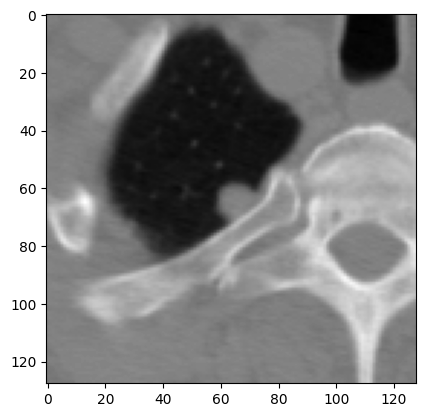

In [8]:
plt.imshow(train_images[2], cmap='gray', vmin=0, vmax=255)
plt.show()

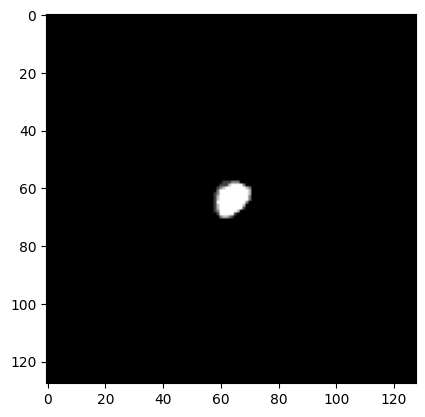

In [9]:
plt.imshow(train_masks[2], cmap='gray', vmin=0, vmax=255)
plt.show()

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
def unet_model(input_shape):
    inputs = layers.Input(input_shape)  # input_shape = (height, width, 3)

    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    u5 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)  

    model = models.Model(inputs, outputs)
    return model


input_shape = (128, 128, 1)
model = unet_model(input_shape)

In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 256)    │        524,544 │ conv2d_7[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 512)    │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 256)    │      1,179,904 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 64, 64, 128)    │        131,200 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)    

 Total params: 7,696,193 (29.36 MB)

 Trainable params: 7,696,193 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
train_images=np.expand_dims(train_images, axis=3)
train_masks=np.expand_dims(train_masks, axis=3)
val_images=np.expand_dims(val_images, axis=3)
val_masks=np.expand_dims(val_masks, axis=3)
test_images=np.expand_dims(test_images, axis=3)
test_masks=np.expand_dims(test_masks, axis=3)

In [13]:
print(train_images.shape)
print(train_masks.shape)
print(val_images.shape)
print(val_masks.shape)
print(test_images.shape)
print(test_masks.shape)

(11731, 128, 128, 1)
(11731, 128, 128, 1)
(1878, 128, 128, 1)
(1878, 128, 128, 1)
(1877, 128, 128, 1)
(1877, 128, 128, 1)


In [14]:
train_masks=(train_masks > 0).astype(np.float32)
val_masks=(val_masks > 0).astype(np.float32)
test_masks=(test_masks > 0).astype(np.float32)

In [41]:
train_masks = np.squeeze(train_masks) 
mean_image = np.mean(train_masks, axis=0)  

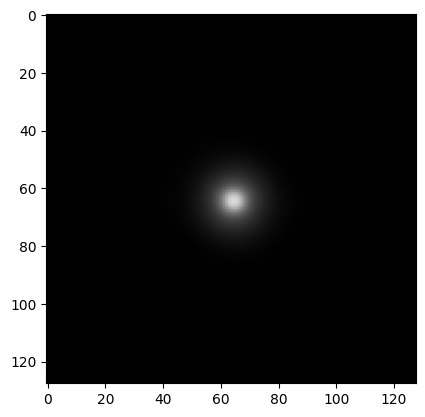

In [42]:
plt.imshow(mean_image, cmap='gray', vmin=0, vmax=1)
plt.show()

In [43]:
mean_image.shape

(128, 128)

In [44]:
mean_image

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [45]:
mean_image=(mean_image > 0.2).astype(np.float32)

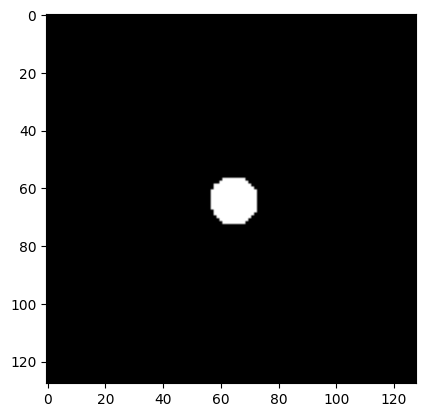

In [46]:
plt.imshow(mean_image, cmap='gray', vmin=0, vmax=1)
plt.show()

In [47]:
test_masks.shape

(1877, 128, 128, 1)

In [48]:
tensor = np.tile(mean_image, (1877, 1, 1)) 
tensor=np.expand_dims(tensor, axis=-1)
tensor.shape

(1877, 128, 128, 1)

In [50]:
train_masks=np.expand_dims(train_masks, axis=-1)
train_masks.shape

(11731, 128, 128, 1)

In [52]:
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + 1e-6)

def dice_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-6)

def precision_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    true_positives = tf.reduce_sum(y_true * y_pred)
    predicted_positives = tf.reduce_sum(y_pred)
    return true_positives / (predicted_positives + 1e-6)

def recall_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    true_positives = tf.reduce_sum(y_true * y_pred)
    possible_positives = tf.reduce_sum(y_true)
    return true_positives / (possible_positives + 1e-6)

def f1_metric(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    return 2 * (precision * recall) / (precision + recall + 1e-6)


iou_scores = []
dice_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for i in range(len(test_masks)):
    y_true = test_masks[i]
    y_pred = tensor[i]

    iou_scores.append(iou_metric(y_true, y_pred))
    dice_scores.append(dice_metric(y_true, y_pred))
    precision_scores.append(precision_metric(y_true, y_pred))
    recall_scores.append(recall_metric(y_true, y_pred))
    f1_scores.append(f1_metric(y_true, y_pred))

print(f"IoU: {np.mean(iou_scores):.4f}")
print(f"Dice: {np.mean(dice_scores):.4f}")
print(f"Precision: {np.mean(precision_scores):.4f}")
print(f"Recall: {np.mean(recall_scores):.4f}")
print(f"F1-score: {np.mean(f1_scores):.4f}")

IoU: 0.2747
Dice: 0.3922
Precision: 0.3529
Recall: 0.8366
F1-score: 0.3922


In [25]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
def dice_loss(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

def combined_loss(y_true, y_pred, alpha=0.5, beta=0.5):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return alpha * bce + beta * dice

def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + 1e-6)

def dice_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-6)

def precision_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    true_positives = tf.reduce_sum(y_true * y_pred)
    predicted_positives = tf.reduce_sum(y_pred)
    return true_positives / (predicted_positives + 1e-6)

def recall_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    true_positives = tf.reduce_sum(y_true * y_pred)
    possible_positives = tf.reduce_sum(y_true)
    return true_positives / (possible_positives + 1e-6)

def f1_metric(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    return 2 * (precision * recall) / (precision + recall + 1e-6)


optimizer=Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer, loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, alpha=0.5, beta=0.5), 
              metrics=[iou_metric, dice_metric, precision_metric, recall_metric, f1_metric])

callbacks = [
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min'),
]

history=model.fit(
    train_images, train_masks,
    validation_data=(val_images, val_masks),
    epochs=20, batch_size=64, callbacks=callbacks
)


Epoch 1/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 132s 677ms/step - dice_metric: 0.2337 - f1_metric: 0.2337 - iou_metric: 0.1615 - loss: 0.4363 - precision_metric: 0.2633 - recall_metric: 0.2435 - val_dice_metric: 0.6729 - val_f1_metric: 0.6729 - val_iou_metric: 0.5246 - val_loss: 0.1920 - val_precision_metric: 0.7272 - val_recall_metric: 0.6536
Epoch 2/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 122s 662ms/step - dice_metric: 0.7474 - f1_metric: 0.7474 - iou_metric: 0.5987 - loss: 0.1472 - precision_metric: 0.7830 - recall_metric: 0.7252 - val_dice_metric: 0.7486 - val_f1_metric: 0.7486 - val_iou_metric: 0.6079 - val_loss: 0.1428 - val_precision_metric: 0.7501 - val_recall_metric: 0.7789
Epoch 3/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 122s 664ms/step - dice_metric: 0.8022 - f1_metric: 0.8022 - iou_metric: 0.6709 - loss: 0.1126 - precision_metric: 0.8196 - recall_metric: 0.7891 - val_dice_metric: 0.7467 - val_f1_metric: 0.7467 - val_iou_metric: 0.6070 - val_loss: 0.1429 - val_precision_metric: 0.8103 - val_recall_m

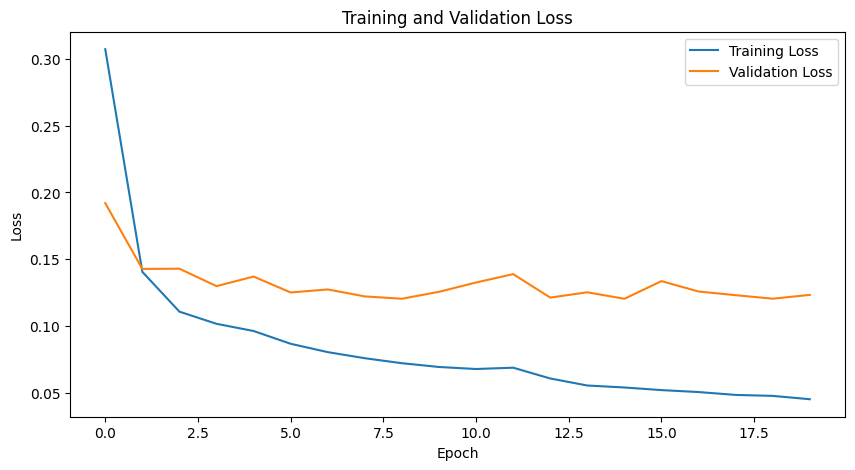

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

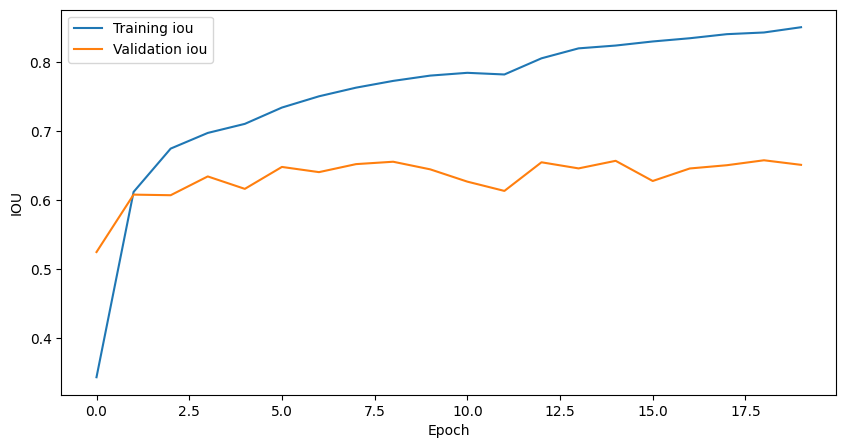

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['iou_metric'], label='Training iou')
plt.plot(history.history['val_iou_metric'], label='Validation iou')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [41]:
from tensorflow import keras

keras.utils.get_custom_objects().update({
    "dice_loss": dice_loss,
    "combined_loss": combined_loss,
    "iou_metric": iou_metric,
    "dice_metric": dice_metric,
    "precision_metric": precision_metric,
    "recall_metric": recall_metric,
    "f1_metric": f1_metric
})
from tensorflow.keras.models import load_model 
model = keras.models.load_model("best_model.keras", safe_mode=False)

In [29]:
model.save('model_cancer.keras')

In [30]:
zero_masks = np.all(train_masks == 0, axis=(1, 2, 3))  

num_zero_images = np.sum(zero_masks)
print(num_zero_images)

0


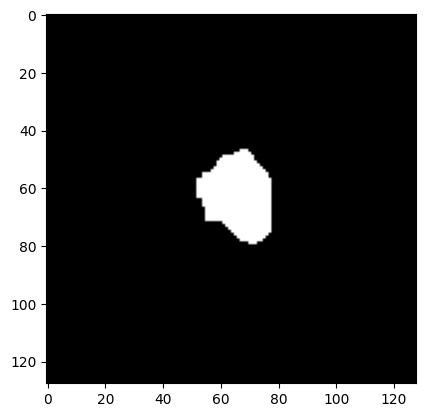

In [31]:
plt.imshow(train_masks[890], cmap='gray', vmin=0, vmax=1)
plt.show()

In [29]:
mean_image = np.mean(train_masks, axis=0)  
mean_image = np.squeeze(mean_image) 

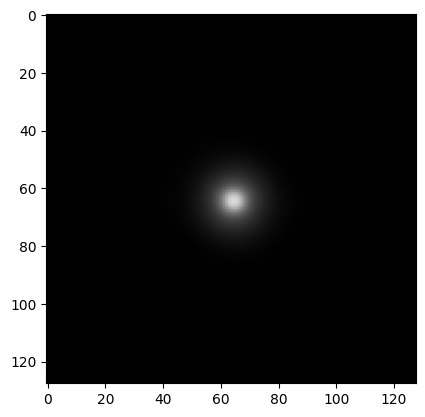

In [30]:
plt.imshow(mean_image, cmap='gray', vmin=0, vmax=1)
plt.show()

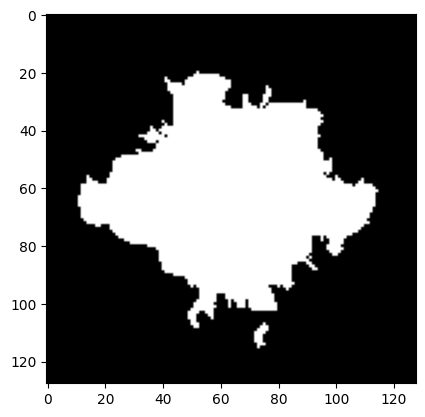

In [31]:
mean_image = np.max(train_masks, axis=0)  
mean_image = np.squeeze(mean_image) 
plt.imshow(mean_image, cmap='gray', vmin=0, vmax=1)
plt.show()

In [43]:

pred_masks = model.predict(test_images)  

threshold = 0.5
pred_masks_binary = (pred_masks > threshold).astype(np.float32)



iou_scores = []
dice_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for i in range(len(test_masks)):
    y_true = test_masks[i]
    y_pred = pred_masks_binary[i]

    iou_scores.append(iou_metric(y_true, y_pred))
    dice_scores.append(dice_metric(y_true, y_pred))
    precision_scores.append(precision_metric(y_true, y_pred))
    recall_scores.append(recall_metric(y_true, y_pred))
    f1_scores.append(f1_metric(y_true, y_pred))

# Усредняем метрики по всем изображениям
print(f"IoU: {np.mean(iou_scores):.4f}")
print(f"Dice: {np.mean(dice_scores):.4f}")
print(f"Precision: {np.mean(precision_scores):.4f}")
print(f"Recall: {np.mean(recall_scores):.4f}")
print(f"F1-score: {np.mean(f1_scores):.4f}")


59/59 ━━━━━━━━━━━━━━━━━━━━ 28s 252ms/step
IoU: 0.5570
Dice: 0.6581
Precision: 0.7247
Recall: 0.6711
F1-score: 0.6581


In [44]:

pred_masks = model.predict(val_images)  

threshold = 0.5
pred_masks_binary = (pred_masks > threshold).astype(np.float32)



iou_scores = []
dice_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for i in range(len(val_masks)):
    y_true = val_masks[i]
    y_pred = pred_masks_binary[i]

    iou_scores.append(iou_metric(y_true, y_pred))
    dice_scores.append(dice_metric(y_true, y_pred))
    precision_scores.append(precision_metric(y_true, y_pred))
    recall_scores.append(recall_metric(y_true, y_pred))
    f1_scores.append(f1_metric(y_true, y_pred))


print(f"IoU: {np.mean(iou_scores):.4f}")
print(f"Dice: {np.mean(dice_scores):.4f}")
print(f"Precision: {np.mean(precision_scores):.4f}")
print(f"Recall: {np.mean(recall_scores):.4f}")
print(f"F1-score: {np.mean(f1_scores):.4f}")


59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step
IoU: 0.5949
Dice: 0.6981
Precision: 0.7422
Recall: 0.7364
F1-score: 0.6981


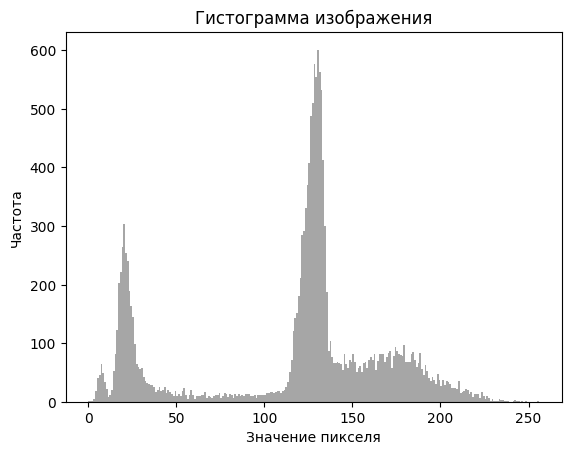

In [45]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


plt.hist(train_images[2].ravel(), bins=256, range=[0,256], color='gray', alpha=0.7)
plt.xlabel("Значение пикселя")
plt.ylabel("Частота")
plt.title("Гистограмма изображения")
plt.show()
